In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import src.cnn as cnn
import src.gmm.bgmm as bgmm 
import src.sampler.create_lc as creator
import src.sampler.fit_regressor as reg
from src.utils import *
from src.vae.datasets import Astro_lightcurves

import yaml
from typing import List, Optional, Any, Dict

with open('src/configuration/paths.yaml', 'r') as file:
    YAML_FILE: Dict[str, Any] = yaml.safe_load(file)

PATHS: Dict[str, str] = YAML_FILE['paths']
PATH_PRIOS: str = PATHS['PATH_PRIOS']
PATH_MODELS: str = PATHS['PATH_MODELS']
PATH_FIGURES: str = PATHS['PATH_FIGURES']

mean_prior_dict: Dict[str, Any] = load_yaml_priors(PATH_PRIOS)

with open('src/configuration/regressor.yaml', 'r') as file:
    config_file: Dict[str, Any] = yaml.safe_load(file)

vae_model: str =   config_file['model_parameters']['ID']   # '1pjeearx'#'20twxmei' trained using TPM using GAIA3 ... using 5 PP 1pjeearx
print('Using vae model: '+ vae_model)
sufix_path: str =   config_file['model_parameters']['sufix_path']
print('sufix path: '+ sufix_path)
PP_list = load_pp_list(vae_model)
print(PP_list)
gpu: bool = True # fail when true is selected

device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")


sufix path: GAIA3_6PP
Using vae model: 3pbpvynz
sufix path: GAIA3_6PP
['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']


In [4]:
def plot_wall_lcs_real_sens(lc_real, cls=[], to_title=None, sensivity=None, column_to_sensivity=None):

    to_title_one = to_title[:,column_to_sensivity]
    to_title = to_title#.cpu().numpy()
    if len(cls) == 0:
        cls = [''] * len(lc_gen)
    plt.close()
    fig, axis = plt.subplots(nrows=8, ncols=3, 
                             figsize=(16,14),
                             sharex=True, sharey=True)
    
    for i, ax in enumerate(axis.flat):
        ax.errorbar(lc_real[i, :, 0],
                    lc_real[i, :, 1],
                    fmt='.', c='gray', alpha=.5)
        try:
            print(sensivity + ': ' + str(np.round(to_title_one[i],2)))
            ax.text(0.05, 0.95, sensivity + ': ' + str(np.round(to_title_one[i],3)),
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes, fontsize=10)
        except Exception as error:
            raise(error)

    axis[-1,1].set_xlabel('Phase', fontsize=20)
    axis[4,0].set_ylabel('Normalized Magnitude', fontsize=20)
    title = "Real light curves"
    fig.suptitle(title, fontsize=20, y=0.9)
    fig.subplots_adjust(hspace=0, wspace=0)
    axis[0,0].invert_yaxis()
    feature = str(sensivity).replace('[', '').replace(']','').replace('_','').replace('/','')
    plt.savefig(PATH_FIGURES+'_'+str(feature)+'_'+config_file['model_parameters']['ID']+'_'+str(cls[0])+'_rs_.pdf')
    return 

def get_synthetic_light_curves_rlc(samples: np.ndarray, z_hat: np.ndarray, training_cnn: bool = False, 
        plot:bool = False, save_plot:bool = False, 
        objects_by_class = {'ACEP':12,  'RRLYR':  12}, 
        plot_reverted: bool = False,
        sensivity = None, 
        column_to_sensivity = None, real_sentitive = True  ) -> None:
    
    print('cuda: ', torch.cuda.is_available())
    print('model: ', vae_model)
    vae, config = load_model_list(ID=vae_model, device=device)
    dataset = prepare_dataset(config)
    df_columns = dataset.phy_names

    meta_aux = dataset.meta.reset_index()
    first_key = list(objects_by_class.keys())[0]
    first_value = objects_by_class[first_key]
    print(dataset.phy_names)

    aux_class = meta_aux.query('Type == "%s"' % first_key)
    print(aux_class.Type.unique())
    print(aux_class)
    aux = sort_and_filter(aux_class,  df_columns=df_columns, primary_col=column_to_sensivity)

    data, lb, onehot, pp = dataset[aux.index]
    data = torch.from_numpy(data).to(device)
    onehot = torch.from_numpy(onehot).to(device)
    pp = torch.from_numpy(pp).to(device)
    
    data = data.cpu().detach().numpy()
    column_to_sensivity = dataset.phy_names.index(sensivity)
    plot_wall_lcs_real_sens(data, cls=lb, to_title = aux[dataset.phy_names].values, sensivity = sensivity, 
                        column_to_sensivity=column_to_sensivity) 

def prepare_dataset(config: Dict[str, Union[str, bool, int]]) -> Astro_lightcurves:
    dataset: Astro_lightcurves = Astro_lightcurves(survey=config['data'],
                                band='I' if config['data'] else 'B',
                                use_time=True,
                                use_err=True,
                                norm=config['normed'],
                                folded=config['folded'],
                                machine=socket.gethostname(),
                                seq_len=config['sequence_lenght'],
                                phy_params=config['phys_params'])
    if config['classes'].split('_')[0] == 'drop':
        dataset.drop_class(config['classes'].split('_')[1])
    elif config['classes'].split('_')[0] == 'only':
        dataset.only_class(config['classes'].split('_')[1])
    print('Using physical parameters: ', dataset.phy_names)
    dataset.remove_nan()
    return dataset

def sort_and_filter(df, df_columns=[], primary_col=None):
    # Move the primary column to be the first in the list
    df_columns_new = df_columns.copy()
    if primary_col in df_columns_new:
        df_columns_new.remove(primary_col)
    df_columns_new = [primary_col] + df_columns_new

    print(df)
    # Step 1: Sort by the primary (first) column
    df = df.sort_values(by=primary_col)

    # Step 2: Remove duplicates based on the primary (first) sorted column
    df = df.drop_duplicates(subset=primary_col)

    # Step 3: Sort by all columns, making sure the first column is the primary one
    df = df.sort_values(by=df_columns_new)

    df_selected = df.head(24)
    # Step 4: Select the 24 middle objects (you can adjust this as needed)
    '''total_rows = df.shape[0]
    if total_rows >= 24:
        spaced_indices = np.linspace(0, total_rows - 1, 24, dtype=int)
        df_selected = df.iloc[spaced_indices]
    else:
        df_selected = df  # If there are fewer than 24 rows, return the entire DataFrame
    '''
    return df_selected

Period
cuda:  True
model:  3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae 3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/config.yaml
Loading from... 
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
Is model in cuda?  True
Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz
phy_params:  PTARMG
Using physical parameters:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
lcs shape:  (40074, 600, 3)
labels shape:  (40074,)
meta shape:  (40074, 8)
meta_p shape:  (40074, 6)
labels one hot shape:  (40074, 8)
labels int shape:  (40074,)
['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
['ACEP']

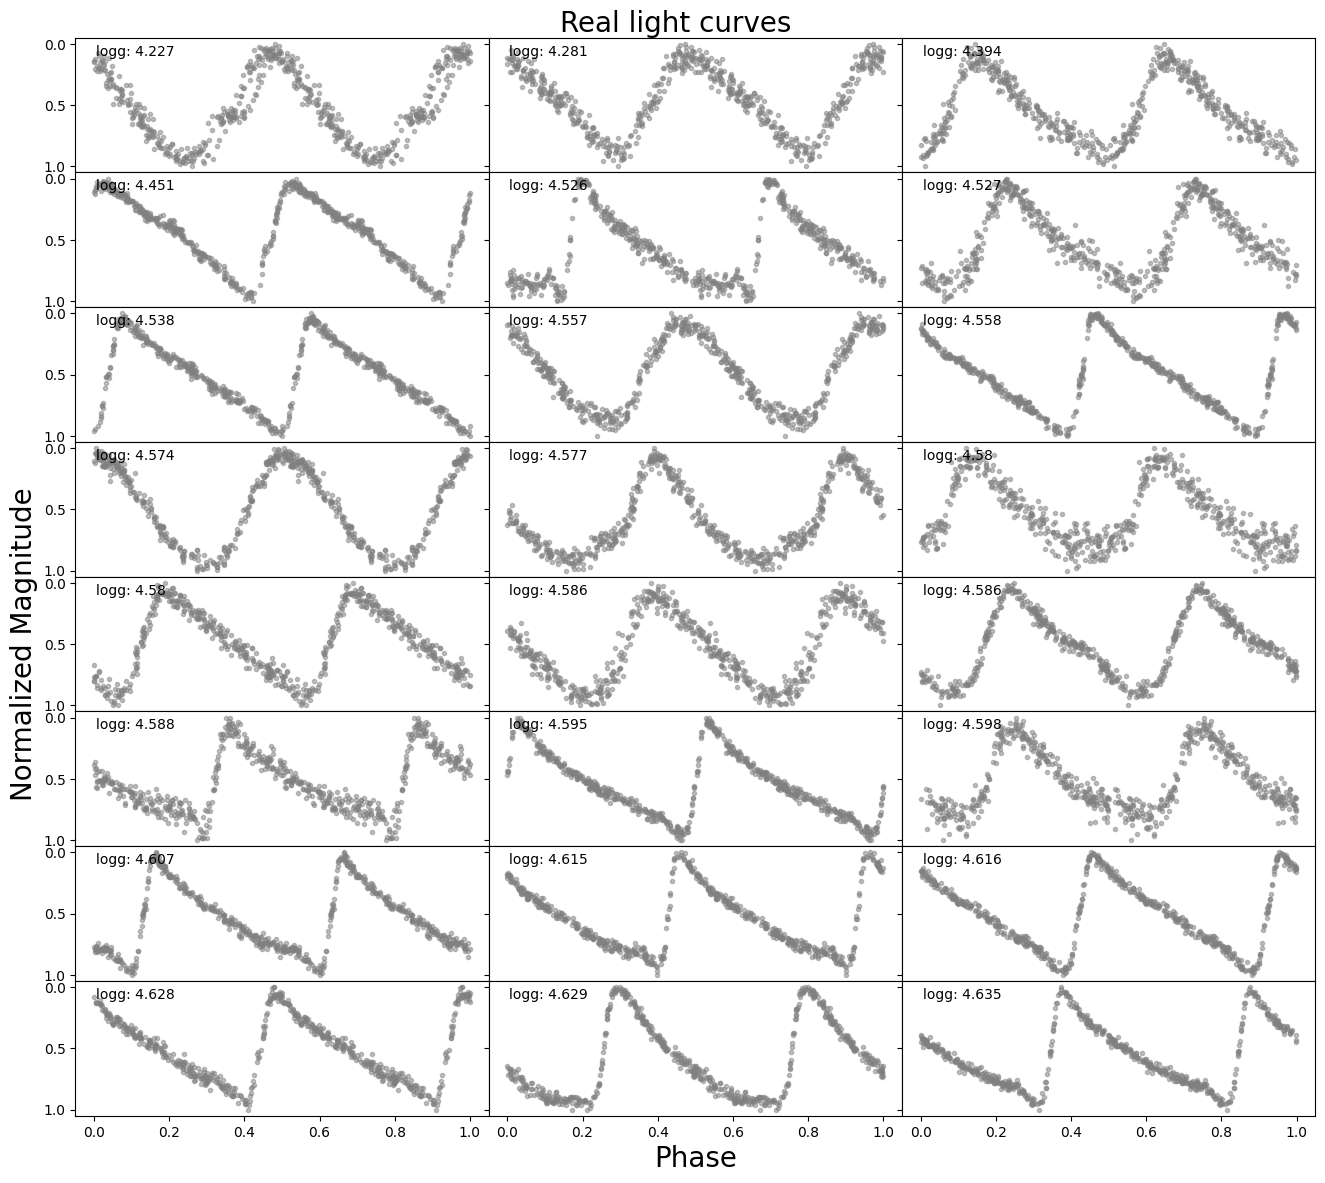

In [5]:
for pp in PP_list:
    print(pp)
    objects_by_class = {'ACEP':24}
    for key, value in objects_by_class.items():
        temp_dict = {key: value}
        get_synthetic_light_curves_rlc(None, None, training_cnn=False, plot=False, save_plot=True,
                                        objects_by_class=temp_dict, sensivity=pp,  
                                        column_to_sensivity=pp)
        del temp_dict


Period
cuda:  True
model:  3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae 3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/config.yaml
Loading from... 
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
Is model in cuda?  True
Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz
phy_params:  PTARMG
Using physical parameters:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
lcs shape:  (40074, 600, 3)
labels shape:  (40074,)
meta shape:  (40074, 8)
meta_p shape:  (40074, 6)
labels one hot shape:  (40074, 8)
labels int shape:  (40074,)
['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
['CEP']


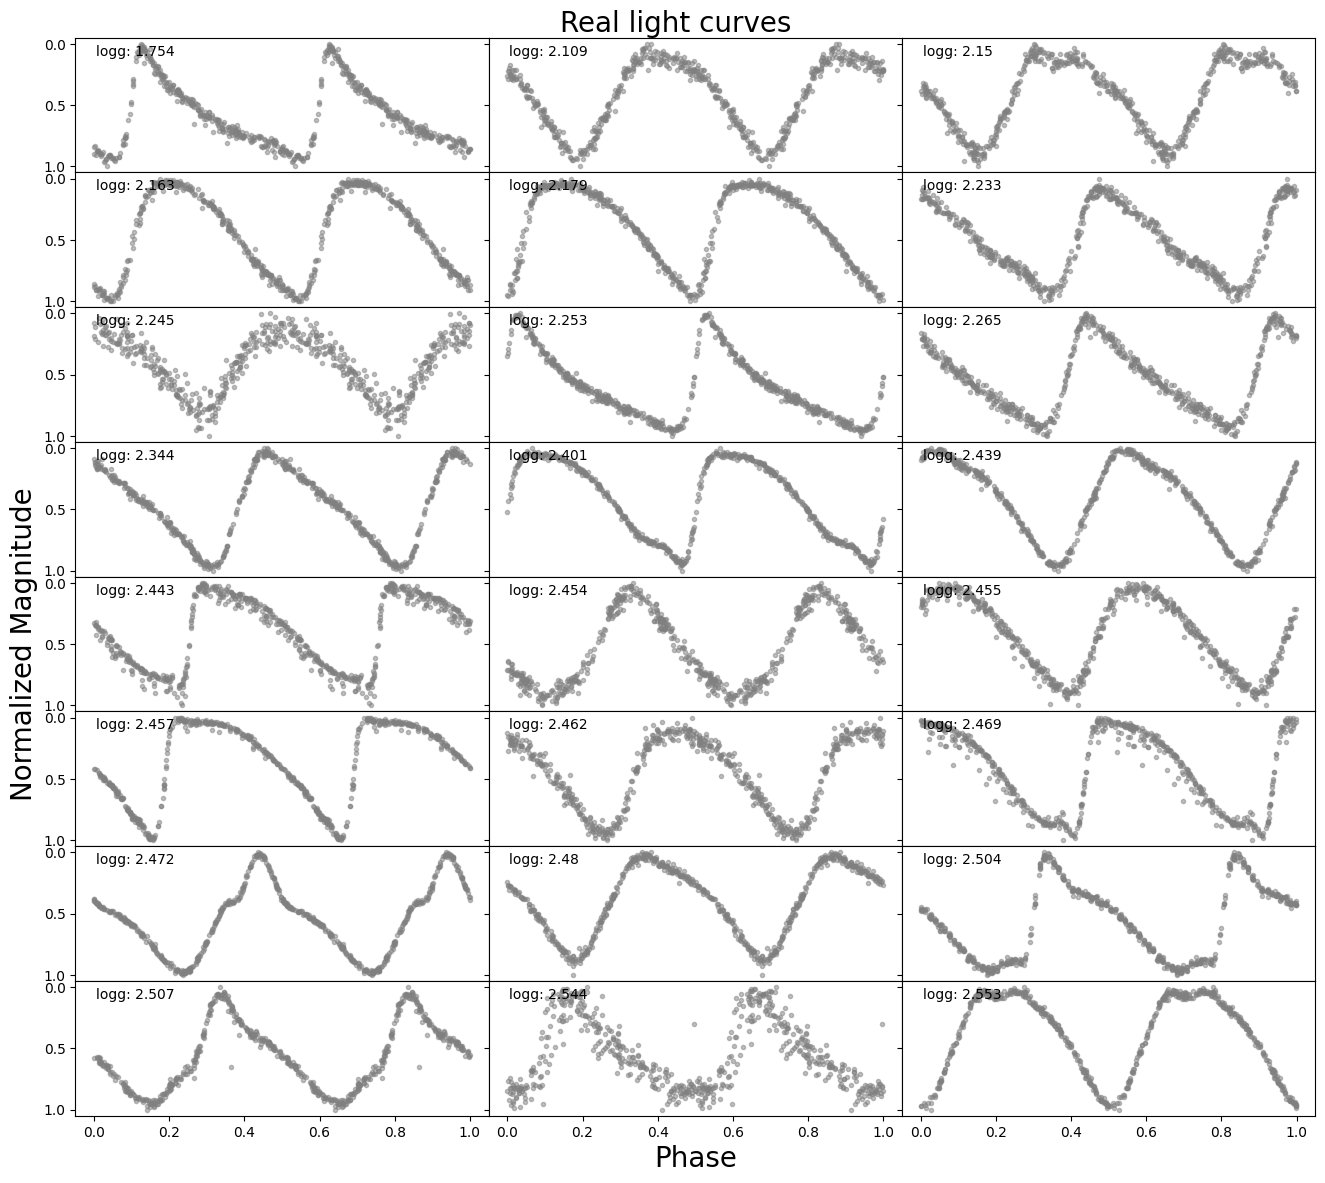

In [6]:
for pp in PP_list:
    print(pp)
    objects_by_class = {'CEP':24}
    for key, value in objects_by_class.items():
        temp_dict = {key: value}
        get_synthetic_light_curves_rlc(None, None, training_cnn=False, plot=False, save_plot=True,
                                        objects_by_class=temp_dict, sensivity=pp,  
                                        column_to_sensivity=pp)
        del temp_dict

Period
cuda:  True
model:  3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae 3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/config.yaml
Loading from... 
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
Is model in cuda?  True
Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz
phy_params:  PTARMG
Using physical parameters:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
lcs shape:  (40074, 600, 3)
labels shape:  (40074,)
meta shape:  (40074, 8)
meta_p shape:  (40074, 6)
labels one hot shape:  (40074, 8)
labels int shape:  (40074,)
['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
['DSCT']

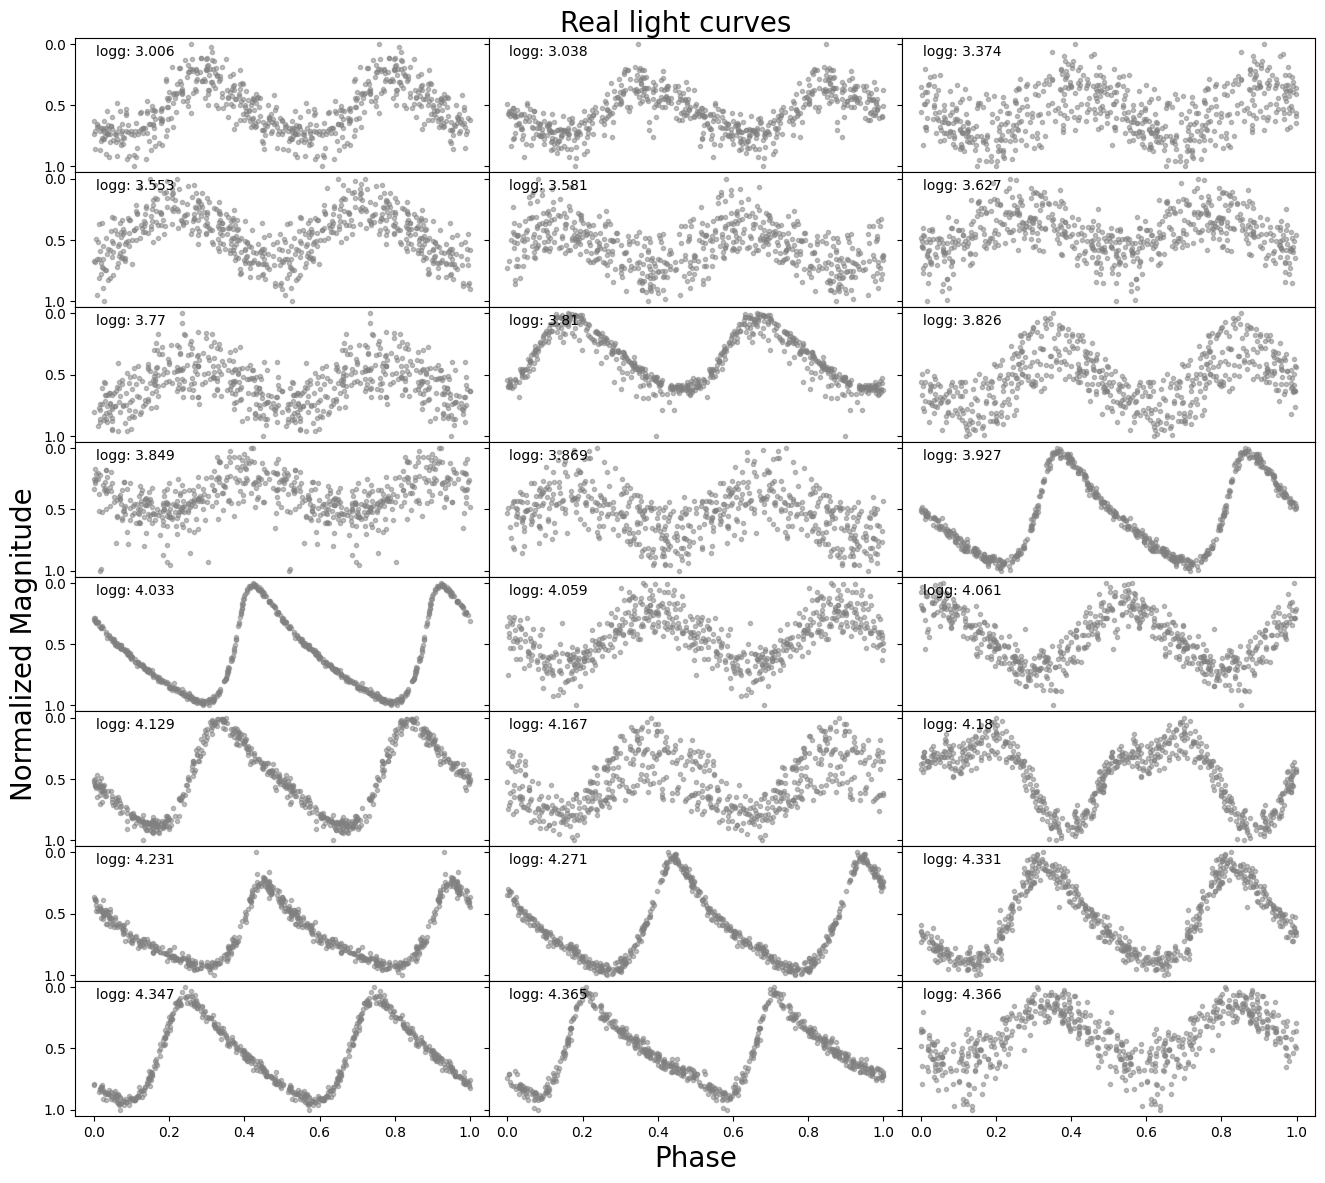

In [7]:
for pp in PP_list:
    print(pp)
    objects_by_class = {'DSCT':24}
    for key, value in objects_by_class.items():
        temp_dict = {key: value}
        get_synthetic_light_curves_rlc(None, None, training_cnn=False, plot=False, save_plot=True,
                                        objects_by_class=temp_dict, sensivity=pp,  
                                        column_to_sensivity=pp)
        del temp_dict

Period
cuda:  True
model:  3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae 3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/config.yaml
Loading from... 
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
Is model in cuda?  True
Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz
phy_params:  PTARMG
Using physical parameters:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
lcs shape:  (40074, 600, 3)
labels shape:  (40074,)
meta shape:  (40074, 8)
meta_p shape:  (40074, 6)
labels one hot shape:  (40074, 8)
labels int shape:  (40074,)
['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
['ECL']


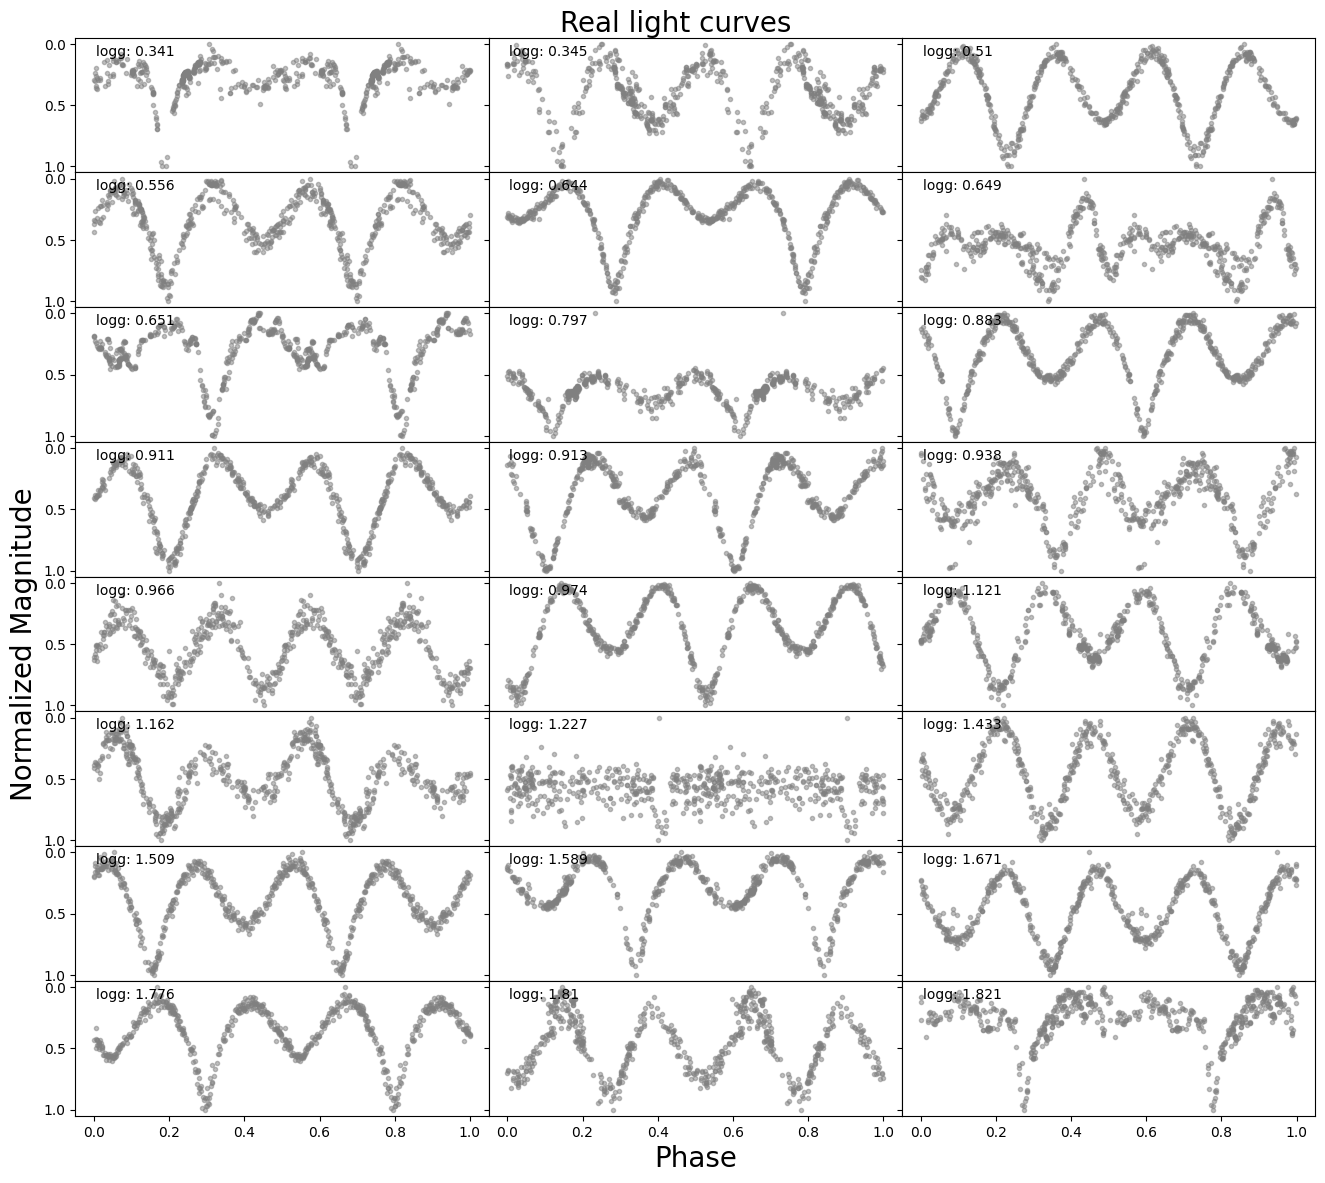

In [8]:
for pp in PP_list:
    print(pp)
    objects_by_class = {'ECL':24}
    for key, value in objects_by_class.items():
        temp_dict = {key: value}
        get_synthetic_light_curves_rlc(None, None, training_cnn=False, plot=False, save_plot=True,
                                        objects_by_class=temp_dict, sensivity=pp,  
                                        column_to_sensivity=pp)
        del temp_dict

Period
cuda:  True
model:  3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae 3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/config.yaml
Loading from... 
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
Is model in cuda?  True
Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz
phy_params:  PTARMG
Using physical parameters:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
lcs shape:  (40074, 600, 3)
labels shape:  (40074,)
meta shape:  (40074, 8)
meta_p shape:  (40074, 6)
labels one hot shape:  (40074, 8)
labels int shape:  (40074,)
['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
['ELL']


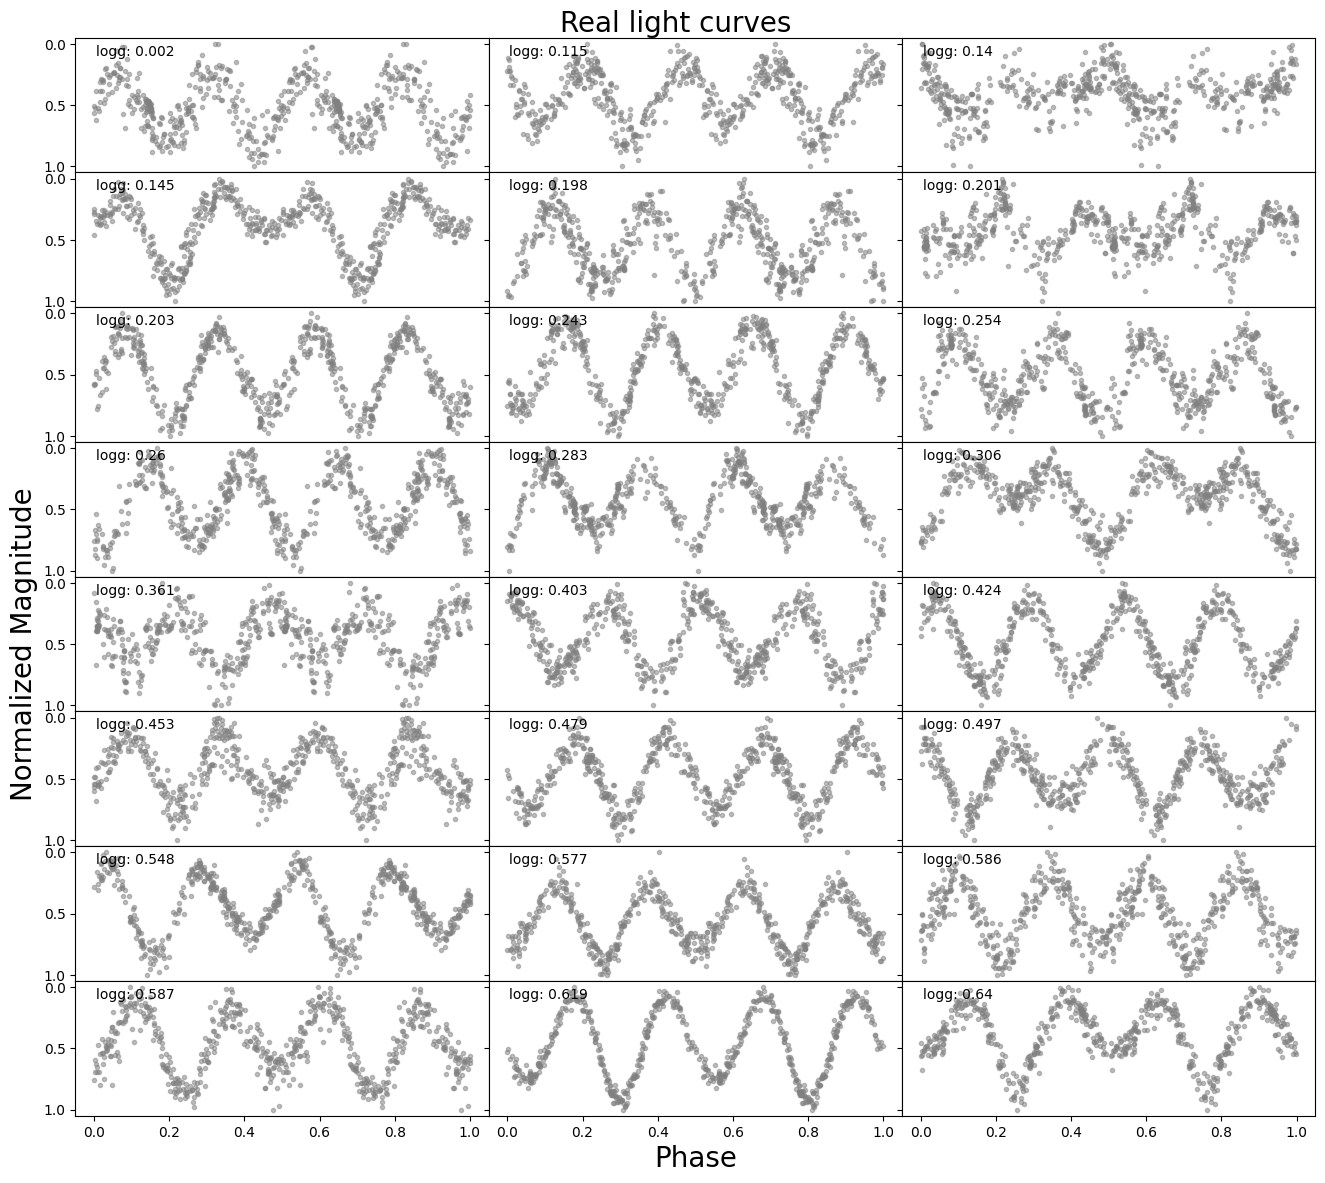

In [9]:
for pp in PP_list:
    print(pp)
    objects_by_class = {'ELL':24}
    for key, value in objects_by_class.items():
        temp_dict = {key: value}
        get_synthetic_light_curves_rlc(None, None, training_cnn=False, plot=False, save_plot=True,
                                        objects_by_class=temp_dict, sensivity=pp,  
                                        column_to_sensivity=pp)
        del temp_dict

Period
cuda:  True
model:  3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae 3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/config.yaml
Loading from... 
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
Is model in cuda?  True
Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz
phy_params:  PTARMG
Using physical parameters:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
lcs shape:  (40074, 600, 3)
labels shape:  (40074,)
meta shape:  (40074, 8)
meta_p shape:  (40074, 6)
labels one hot shape:  (40074, 8)
labels int shape:  (40074,)
['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
['LPV']


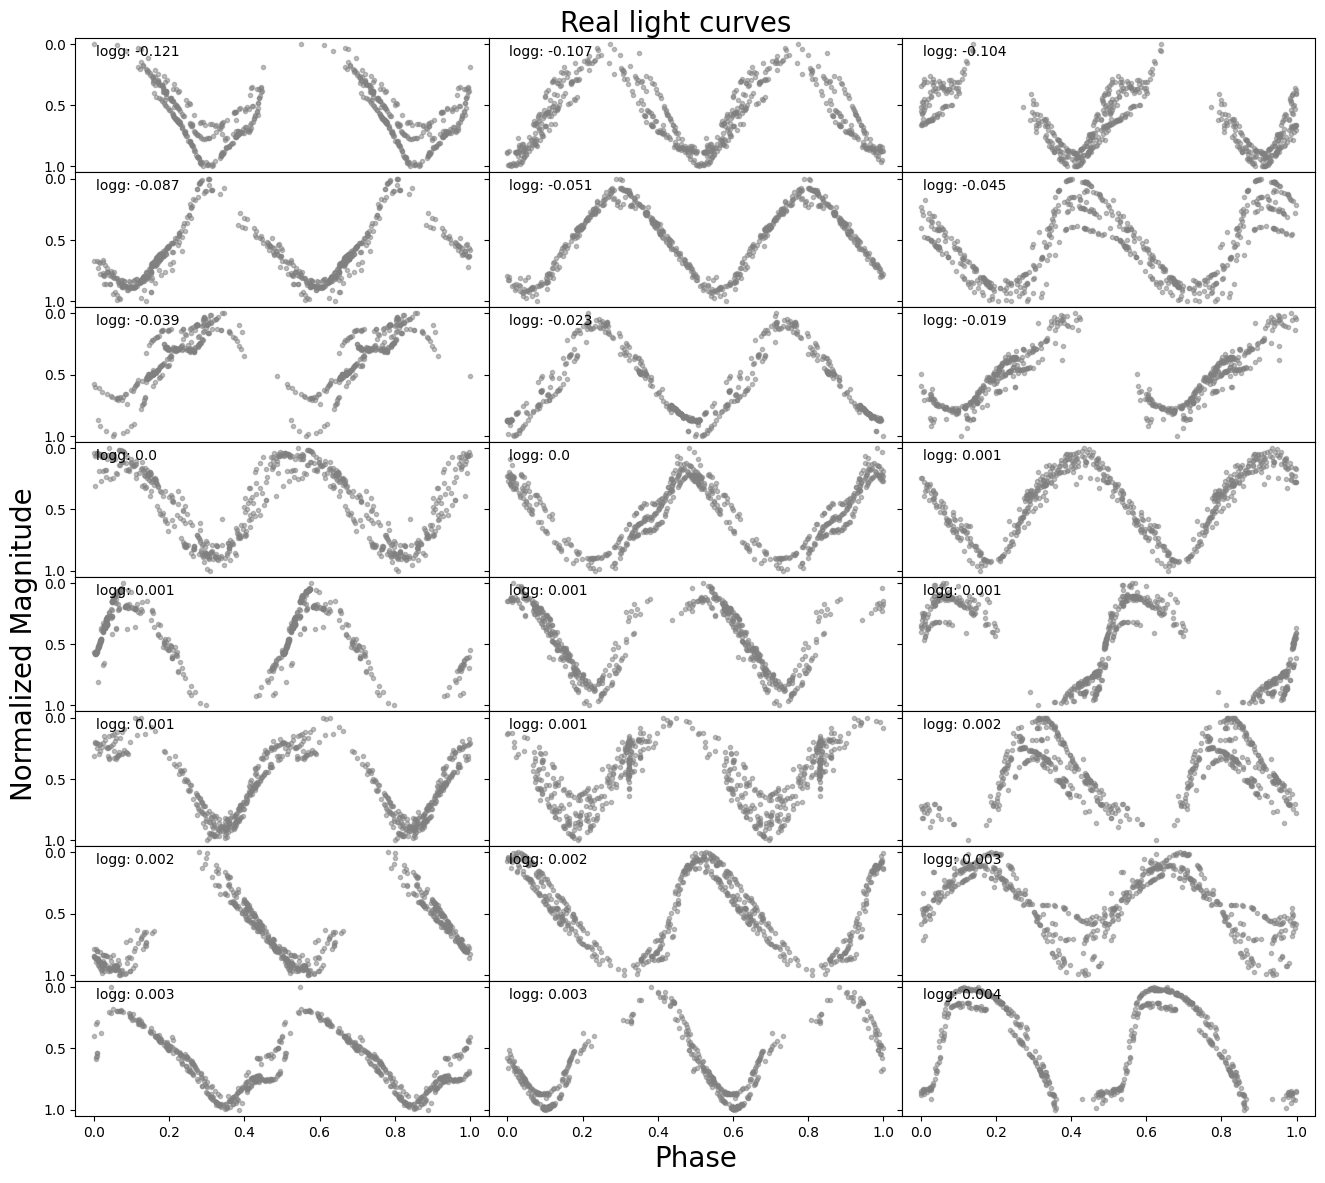

In [10]:
for pp in PP_list:
    print(pp)
    objects_by_class = {'LPV':24}
    for key, value in objects_by_class.items():
        temp_dict = {key: value}
        get_synthetic_light_curves_rlc(None, None, training_cnn=False, plot=False, save_plot=True,
                                        objects_by_class=temp_dict, sensivity=pp,  
                                        column_to_sensivity=pp)
        del temp_dict

Period
cuda:  True
model:  3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae 3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/config.yaml
Loading from... 
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
Is model in cuda?  True
Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz
phy_params:  PTARMG
Using physical parameters:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
lcs shape:  (40074, 600, 3)
labels shape:  (40074,)
meta shape:  (40074, 8)
meta_p shape:  (40074, 6)
labels one hot shape:  (40074, 8)
labels int shape:  (40074,)
['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
['RRLYR'

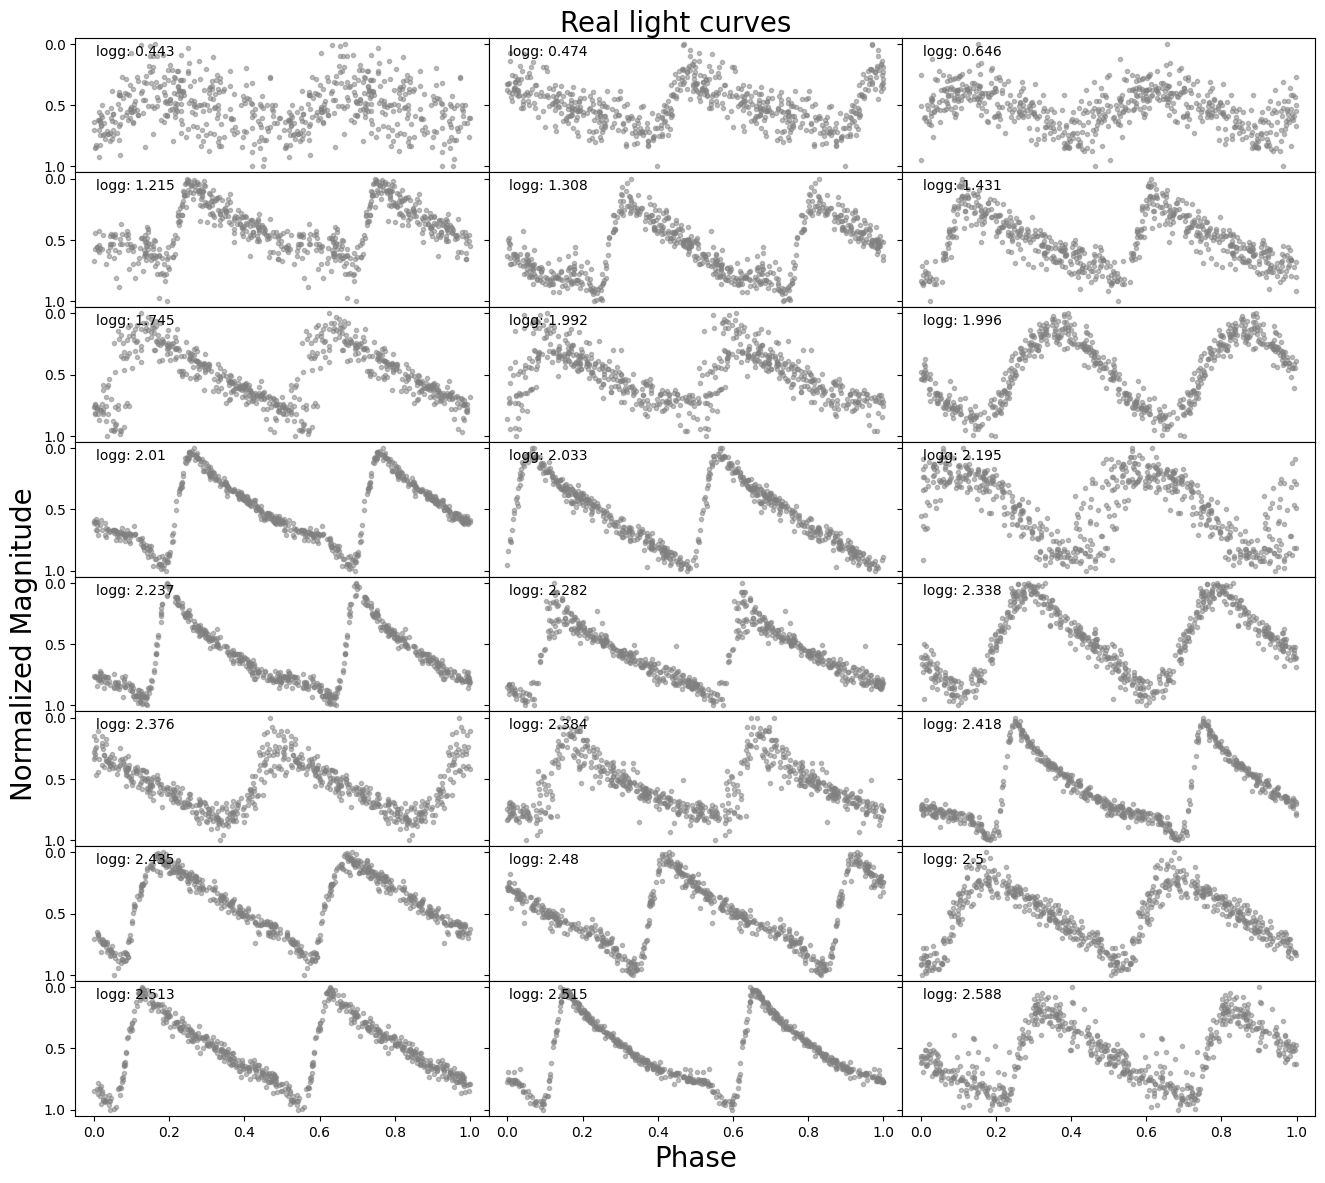

In [11]:
for pp in PP_list:
    print(pp)
    objects_by_class = {'RRLYR':24}
    for key, value in objects_by_class.items():
        temp_dict = {key: value}
        get_synthetic_light_curves_rlc(None, None, training_cnn=False, plot=False, save_plot=True,
                                        objects_by_class=temp_dict, sensivity=pp,  
                                        column_to_sensivity=pp)
        del temp_dict

Period
cuda:  True
model:  3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae 3pbpvynz
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/config.yaml
Loading from... 
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/wandb/run--3pbpvynz/VAE_model_hardy-water-182.pt
Is model in cuda?  True
Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz
phy_params:  PTARMG
Using physical parameters:  ['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
lcs shape:  (40074, 600, 3)
labels shape:  (40074,)
meta shape:  (40074, 8)
meta_p shape:  (40074, 6)
labels one hot shape:  (40074, 8)
labels int shape:  (40074,)
['Period', 'teff_val', '[Fe/H]_J95', 'abs_Gmag', 'radius_val', 'logg']
['T2CEP'

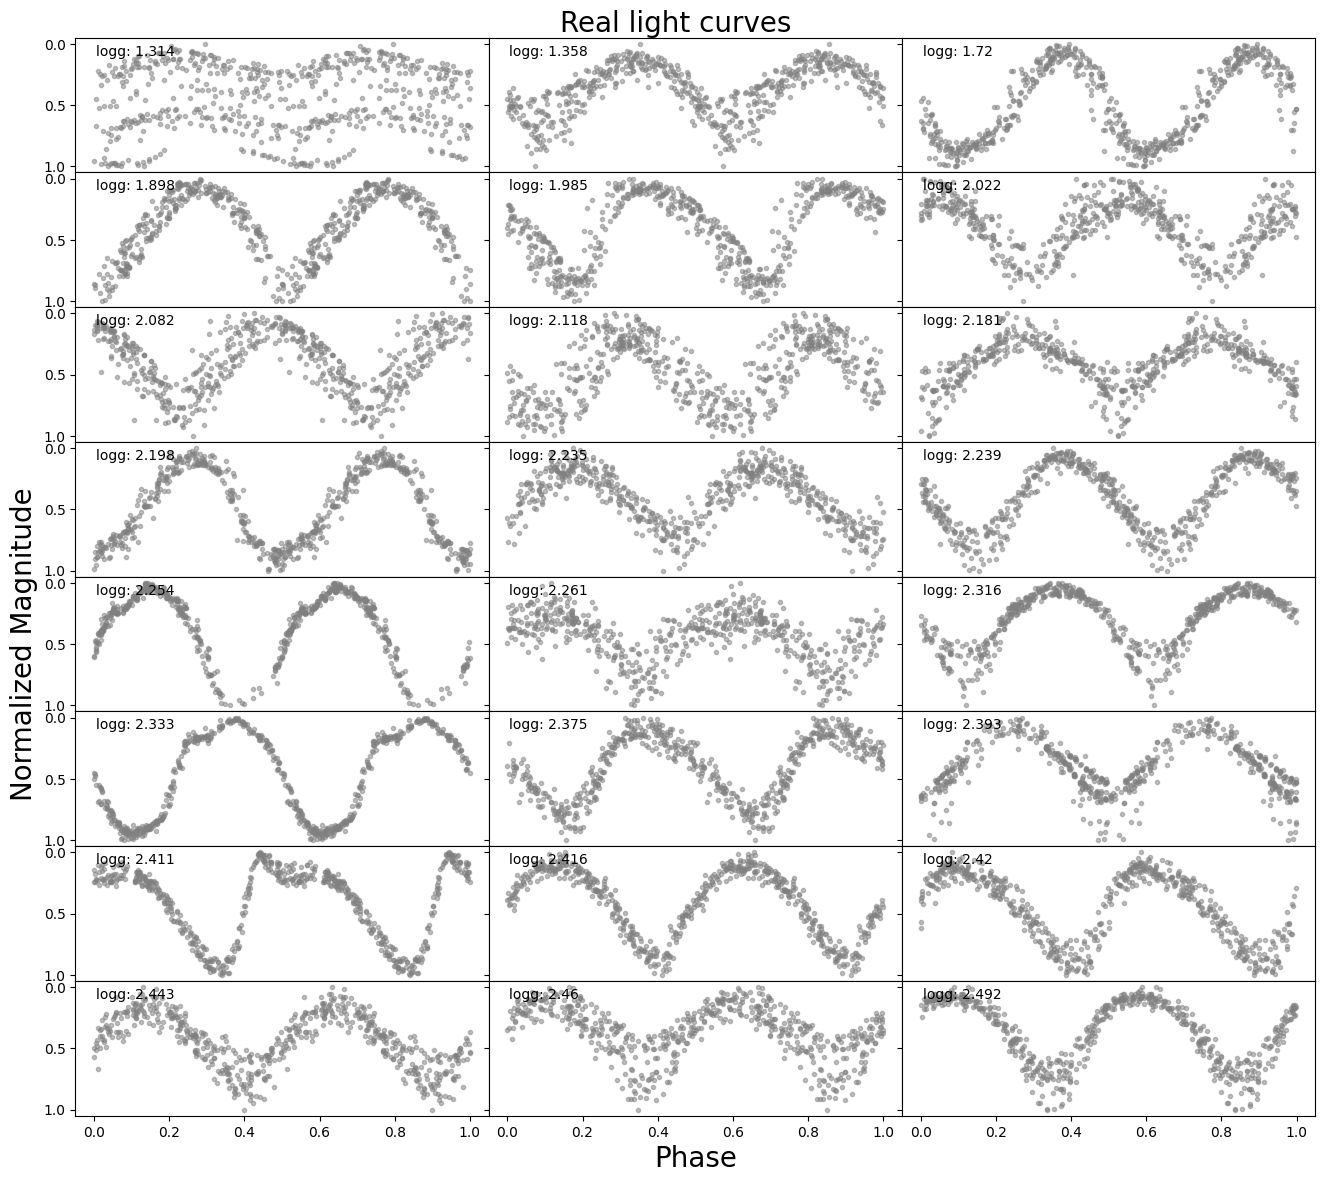

In [12]:
for pp in PP_list:
    print(pp)
    objects_by_class = {'T2CEP':24}
    for key, value in objects_by_class.items():
        temp_dict = {key: value}
        get_synthetic_light_curves_rlc(None, None, training_cnn=False, plot=False, save_plot=True,
                                        objects_by_class=temp_dict, sensivity=pp,  
                                        column_to_sensivity=pp)
        del temp_dict